<a href="https://colab.research.google.com/github/ComputationalScienceLaboratory/control-pinn/blob/main/ControlPINN_HeatEquation_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-informed neural networks for PDE-constrained optimization and control
## Jostein Barry-Straume, Arash Sarshar, Andrey A. Popov, Adrian Sandu
## [Computational Science Lab](https://csl.cs.vt.edu/), Department of Computer Science, Virginia Tech

> Paper and Code can be found here: https://github.com/ComputationalScienceLaboratory/control-pinn

> This Google Colab notebook contains the code for training a Control PINN model on an open-loop optimal control problem for a one-dimensional heat equation

In [1]:
'''
Import the necessary libraries
'''
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Supress INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')
# https://github.com/BundleOfKent/GradientDescentAnimation_NeuralNetwork/blob/main/NeuralNet_Medium.py

## Decouple with Sparse Data

In [2]:
def y_ref(t, x):
  '''
  Reference solution of system state y
  :param t: time, needs to be a scalar
  :param x: space, can be a vector
  :return: numpy array of the reference solution of the system state y
  '''
  Pi = np.pi
  Pi2 = Pi*Pi
  Pi3 = Pi2*Pi
  Pihalf = Pi/2.0
  out = (2.0*(np.exp(-(Pi2*t)) - np.cos(Pihalf*t) + 2.0*Pi*np.sin(Pihalf*t))*np.sin(Pi*x))/(Pi + 4.0*Pi3)
  return out

def u_ref(t, x):
  '''
  Reference solution of system control u
  :param t: time, needs to be a scalar
  :param x: space, can be a vector
  :return: numpy array of the reference solution of the system control u
  '''
  return np.sin(np.pi*x) * np.sin(np.pi*t/2.0)

## Control PINN Model Class

In [3]:
class PINNModel(keras.Model):
  def __init__(self, num_unit=100, debug=0):
    '''
    Initialize the model object.
    :param num_unit: Number of nodes per layer, default is 100
    :param debug: If zero, prints to console the values of
                  systemPushBack, systemControl, and pdeLoss. Default is zero
    '''
    super(PINNModel, self).__init__()

    self.num_unit       = num_unit
    self.debug          = debug
    self.u              = None
    self.l              = None
    self.y              = None
    self.out            = None
    self.f              = None
    self.g              = None
    self.dydxx          = None
    self.dydt           = None
    self.dldt           = None
    self.dfdy           = None
    self.dfdu           = None
    self.dgdy           = None
    self.dgdu           = None
    self.pdeLoss        = None
    self.systemPushBack = None
    self.systemControl  = None

    # Layers of the neural network
    # https://github.com/tensorflow/tensorflow/issues/28799
    dim = (2,)
    dim = np.array(dim)
    act = 'elu'
    self.input_concat   = keras.layers.Concatenate(axis=1, name = 'input_concat')
    self.hidden_layer_1 = keras.layers.Dense(input_shape = dim, units=self.num_unit, name='hidden1', activation=act)
    self.hidden_layer_2 = keras.layers.Dense(units=self.num_unit, name='hidden2', activation=act)
    self.hidden_layer_3 = keras.layers.Dense(units=self.num_unit, name='hidden3', activation=act)
    self.hidden_layer_4 = keras.layers.Dense(units=self.num_unit, name='hidden4', activation=act)
    self.hidden_layer_5 = keras.layers.Dense(units=self.num_unit, name='hidden5', activation=act)
    self.hidden_layer_6 = keras.layers.Dense(units=self.num_unit, name='hidden6', activation=act)
    self.hidden_layer_7 = keras.layers.Dense(units=self.num_unit, name='hidden7', activation=act)
    self.hidden_layer_8 = keras.layers.Dense(units=self.num_unit, name='hidden8', activation=act)
    self.hidden_layer_9 = keras.layers.Dense(units=self.num_unit, name='hidden9', activation=act)
    self.hidden_layer_10 = keras.layers.Dense(units=self.num_unit, name='hidden10', activation=act)
    self.output_u_tilde = keras.layers.Dense(1, name='output_u_tilde')
    self.output_l_tilde = keras.layers.Dense(1, name='output_l_tilde')
    self.output_y_tilde = keras.layers.Dense(1, name='output_y_tilde')
    self.y_concat       = keras.layers.Concatenate(axis=1, name = 'y_concat')
    self.l_concat       = keras.layers.Concatenate(axis=1, name = 'l_concat')
    self.u_concat       = keras.layers.Concatenate(axis=1, name = 'u_concat')
    self.output_concat  = keras.layers.Concatenate(axis=1,  name = 'output_concat')

  def get_config(self):
    '''
    Returns the configuration settings of the model class
    '''
    cfg = super().get_config()
    return cfg

  @classmethod
  def from_config(cls, config):
    return cls(**config)

  def call(self, t, x):
    '''
    Train the model

    The parameter persistent=True is needed in order to calculate
    multiple gradients with different derivatives, which means the
    gradient tape needs to watch multiple tensors
    '''
    with tf.GradientTape(persistent=True) as tape, tf.GradientTape(persistent=True) as tape2:
      tape.watch(t)
      tape.watch(x)

      tx       = self.input_concat([t, x])
      h1       = self.hidden_layer_1(tx)
      h2       = self.hidden_layer_2(h1)
      h3       = self.hidden_layer_3(h2)
      h4       = self.hidden_layer_4(h3)
      h5       = self.hidden_layer_5(h4)
      y        = self.output_y_tilde(h5)
      u_input  = self.u_concat([y, h5])
      h6       = self.hidden_layer_6(u_input)
      h7       = self.hidden_layer_7(h6)
      h8       = self.hidden_layer_8(h7)
      u        = self.output_u_tilde(h8)
      l_input  = self.l_concat([y, u, h8])
      h9       = self.hidden_layer_9(l_input)
      h10      = self.hidden_layer_10(h9)
      l        = self.output_l_tilde(h10)
      out      = self.output_concat([y, l,  u])
      g        = tf.multiply(0.5, tf.square(u))

      dydx  = tape.gradient(y, x)
      dydxx = tape.gradient(dydx, x)
      f     = tf.add(u, tf.multiply(1.0,dydxx))
      dfdy  = tape.gradient(f, y) # Derivative of f(y(t),u(t)) w.r.t. y
      dydt  = tape.gradient(y, t) # Derivative of y w.r.t. t
      dldt  = tape.gradient(l, t) # Derivative of lambda (l) w.r.t. t 
      dfdu  = tape.gradient(f, u) # Derivative of f(y(t),u(t)) w.r.t. u
      dgdy  = tape.gradient(g, y) # Derivative of g(y(t),u(t)) w.r.t. y
      dgdu  = tape.gradient(g, u) # Derivative of g(y(t),u(t)) w.r.t. u
      
      # Store various information in the model
      self.u = u
      self.l = l
      self.y = y
      self.f = f
      self.g = g
      self.dydx = dydx
      self.dydxx = dydxx
      self.dydt = dydt
      self.dldt = dldt
      self.dfdy = dfdy
      self.dfdu = dfdu
      self.dgdy = dgdy
      self.dgdu = dgdu

    # Fourth term of extended loss function
    pdeLoss = tf.subtract(dydt, f)
    pdeLoss = tf.reduce_sum(tf.square(pdeLoss))
    self.add_loss(pdeLoss)
    self.pdeLoss = pdeLoss

    # Fifth term of extended loss function
    systemPushBack = tf.add(dldt, tf.multiply(dfdy, l))
    systemPushBack = tf.add(systemPushBack, dgdy)
    systemPushBack = tf.reduce_sum(tf.square(systemPushBack))
    self.add_loss(systemPushBack)
    self.systemPushBack = systemPushBack

    # Sixth term of extended loss function
    systemControl = tf.add(tf.multiply(dfdu, l), dgdu)
    systemControl = tf.reduce_sum(tf.square(systemControl))
    self.add_loss(systemControl)
    self.systemControl = systemControl

    if (self.debug == 0):
      print('syspushback: ', systemPushBack)
      print('syscontrol: ', systemControl)
      print('pdeloss: ', pdeLoss)
  
    return out

## Train on One-Dimensional Heat Equation Data

In [4]:
def explicit_MSE_loss(y, yt):
  return tf.reduce_sum(tf.square(tf.subtract(y,yt)))
model = PINNModel()
model.compile(optimizer = keras.optimizers.Adam(lr=1e-3),
              loss = keras.losses.MSE,
              metrics = keras.metrics.MSE)
import warnings 
warnings.filterwarnings('ignore')
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = explicit_MSE_loss

2,000 epochs with Adam at a learning rate of 1e-3


In [5]:
optimizer.learning_rate.assign(1e-3)
epochs           = 2000
steps            = 1
model.debug      = 1
innerIterations  = 1
t_initial        = 0.0
t_final          = 1.0
x_initial        = 0.0
x_final          = 1.0
num_x_points     = 1000
num_t_points     = num_x_points
batchSize        = num_x_points
w_pdeLoss        = 1e-1
w_systemPushback = 1e-1
w_systemControl  = 1e-1

for epoch in range(epochs):
  # Iterate over the batches of a dataset.

  for step in range(steps):
    # Space batch points
    x_batch_train = np.random.uniform(x_initial, x_final, num_x_points).astype('float32')
    
    # Final time
    y_final_time_train = y_ref(t_final, x_batch_train)
    
    # Initial time
    y_initial_time_train = y_ref(t_initial, x_batch_train)
    
    # Time batch points
    t_batch_train = np.random.uniform(t_initial, t_final, num_t_points).astype('float32')
    
    with tf.GradientTape() as tape1:
        
      # Boundary Condition 1
      bc_1_t = tf.reshape(tf.constant(t_batch_train, dtype='float32'), (-1,1))
      bc_1_x = tf.reshape(tf.constant(np.repeat(x_initial, num_t_points), dtype='float32'), (-1,1))
      
      out = model(bc_1_t, bc_1_x)
    
      loss_value_at_bc1 = tf.reduce_sum(
          loss_fn(np.zeros((1,num_t_points), dtype='float32'), out[:,0]))
      
      # Boundary Condition 2
      bc_2_t = tf.reshape(tf.constant(t_batch_train, dtype='float32'), (-1,1))
      bc_2_x = tf.reshape(tf.constant(np.repeat(x_final, num_t_points), dtype='float32'), (-1,1))
      
      out = model(bc_2_t, bc_2_x)
      loss_value_at_bc2 = tf.reduce_sum(
          loss_fn(np.zeros((1,num_t_points), dtype='float32'), out[:,0]))

      # Final Time
      out = model(tf.reshape(tf.constant(np.repeat(t_final, num_x_points)), (-1,1)),
                  tf.reshape(tf.constant(x_batch_train), (-1,1)))
      loss_value_at_final_time = tf.reduce_sum(loss_fn(y_final_time_train,
                                                       out[:,0]))

      # Initial Time
      out = model(tf.reshape(tf.constant(np.repeat(t_initial, num_x_points)),(-1,1)),
                  tf.reshape(x_batch_train,(-1,1)))
      loss_value_at_initial_time = tf.reduce_sum(loss_fn(y_initial_time_train,
                                                         out[:,0]))
      
      loss_value = loss_value_at_final_time\
                 + loss_value_at_initial_time\
                 + loss_value_at_bc1\
                 + loss_value_at_bc2

      # Add extra losses created during this forward pass:
      pinnloss = model.losses[0] * w_pdeLoss\
               + model.losses[1] * w_systemPushback\
               + model.losses[2] * w_systemControl

      for i in range(innerIterations):
        # Subsample time
        sampleResidualPoints = np.random.uniform(x_initial, x_final, size=batchSize) 
        sampleResidualTimes  = np.random.uniform(t_initial, t_final, size=batchSize) 
        sampleResidualPoints = sampleResidualPoints.astype('float32')
        sampleResidualTimes  = sampleResidualTimes.astype('float32')
        out = model(tf.reshape(tf.constant(sampleResidualTimes), (-1,1)),
                  tf.reshape(tf.constant(sampleResidualPoints), (-1,1)))
        
        # Add extra losses created during this forward pass:
        pinnloss += model.losses[0] * w_pdeLoss\
                  + model.losses[1] * w_systemPushback\
                  + model.losses[2] * w_systemControl
      
      loss_value = ((pinnloss / innerIterations) / batchSize) + loss_value

    # Apply gradient based on labeled data
    grads = tape1.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
      f'Epoch {epoch + 1}, '
      f'Step {step}, '
      f'Total Loss: {loss_value}, '
      f'PINN Loss: {pinnloss}')

Epoch 1, Step 0, Total Loss: 41.8232536315918, PINN Loss: 9.77755355834961
Epoch 2, Step 0, Total Loss: 242.2010040283203, PINN Loss: 36.74089050292969
Epoch 3, Step 0, Total Loss: 38.11614227294922, PINN Loss: 8.202300071716309
Epoch 4, Step 0, Total Loss: 28.23788070678711, PINN Loss: 2.27173113822937
Epoch 5, Step 0, Total Loss: 89.86834716796875, PINN Loss: 3.7882518768310547
Epoch 6, Step 0, Total Loss: 74.93318176269531, PINN Loss: 6.042032718658447
Epoch 7, Step 0, Total Loss: 28.015958786010742, PINN Loss: 9.981582641601562
Epoch 8, Step 0, Total Loss: 6.147665977478027, PINN Loss: 14.313875198364258
Epoch 9, Step 0, Total Loss: 15.340723991394043, PINN Loss: 15.46072769165039
Epoch 10, Step 0, Total Loss: 31.224929809570312, PINN Loss: 11.397916793823242
Epoch 11, Step 0, Total Loss: 34.36384582519531, PINN Loss: 5.530086517333984
Epoch 12, Step 0, Total Loss: 24.274341583251953, PINN Loss: 3.6503067016601562
Epoch 13, Step 0, Total Loss: 12.054645538330078, PINN Loss: 7.49385

## Plot Results for One-Dimensional Heat Equation

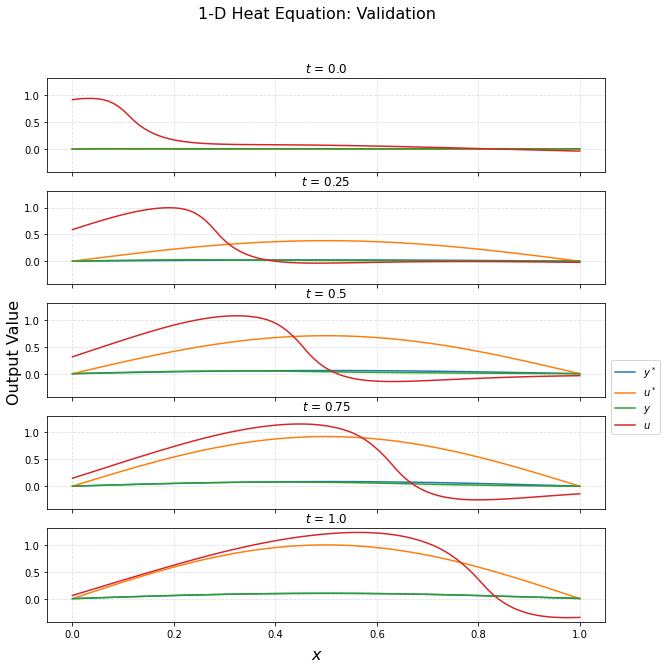

In [17]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')
timespans = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('1-D Heat Equation: Validation', size=16)
fig.text(0.5, 0.08, '$x$', ha='center',va='center', size=16)
fig.text(0.08, 0.5, 'Output Value', ha='center',va='center', rotation='vertical', size=16)
for i in range(len(timespans)):
  axs[i].grid(alpha=.4, linestyle='--')
  axs[i].plot(x_plot, y_ref(timespans[i], x_plot), label='$y^*$')
  axs[i].plot(x_plot, u_ref(timespans[i], x_plot), label='$u^*$')
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[i], 100)),(-1,1)),
            tf.reshape(tf.constant(x_plot), (-1,1)))
  axs[i].plot(x_plot, pred[:,0], label='$y$')
  axs[i].plot(x_plot, pred[:,2], label='$u$')
  axs[i].set_title(f'$t$ = {timespans[i]}',fontsize=12)

plt.legend(loc=(1.01, 2))
plt.show()

### Plots with larger font sizes for publication

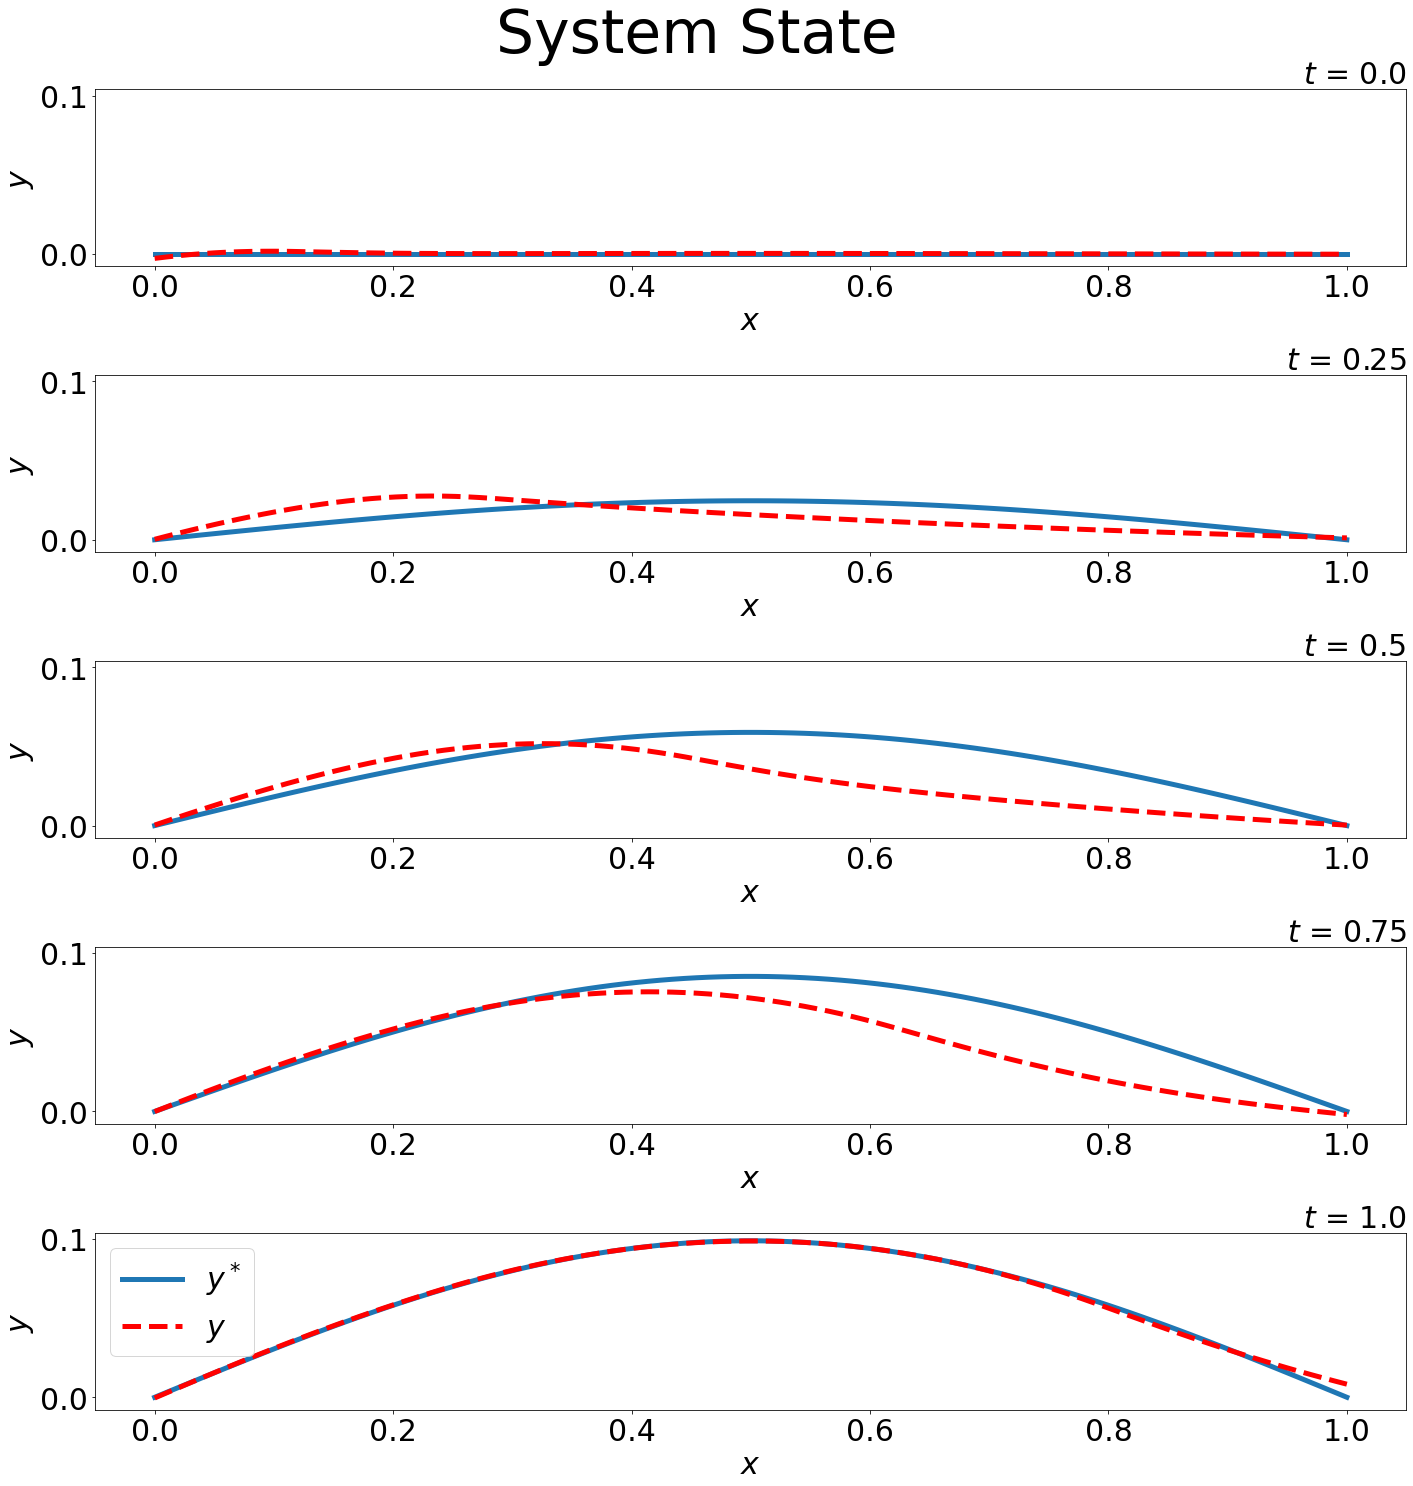

In [15]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')
timespan = 0.0
timespans = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axs = plt.subplots(5, sharex=False, sharey=True, figsize=(20,20),constrained_layout=True)
fig.suptitle('System State', size=60, y=1.03)

for i in range(len(timespans)):
  axs[i].plot(x_plot, y_ref(timespans[i], x_plot), label='$y^*$', linewidth=5)
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[i], 100)),(-1,1)),
            tf.reshape(tf.constant(x_plot), (-1,1)))
  axs[i].plot(x_plot, pred[:,0], '--r', label='$y$', linewidth=5)
  axs[i].set_xlabel('$x$', fontsize=30)
  axs[i].set_ylabel('$y$', fontsize=30)
  axs[i].set_title(f'$t$ = {timespans[i]}', loc='right', size=30)
  axs[i].tick_params(axis='x', labelsize=30)
  axs[i].tick_params(axis='y', labelsize=30)

plt.legend(loc='upper left', fontsize=30)
plt.tight_layout()
plt.show()

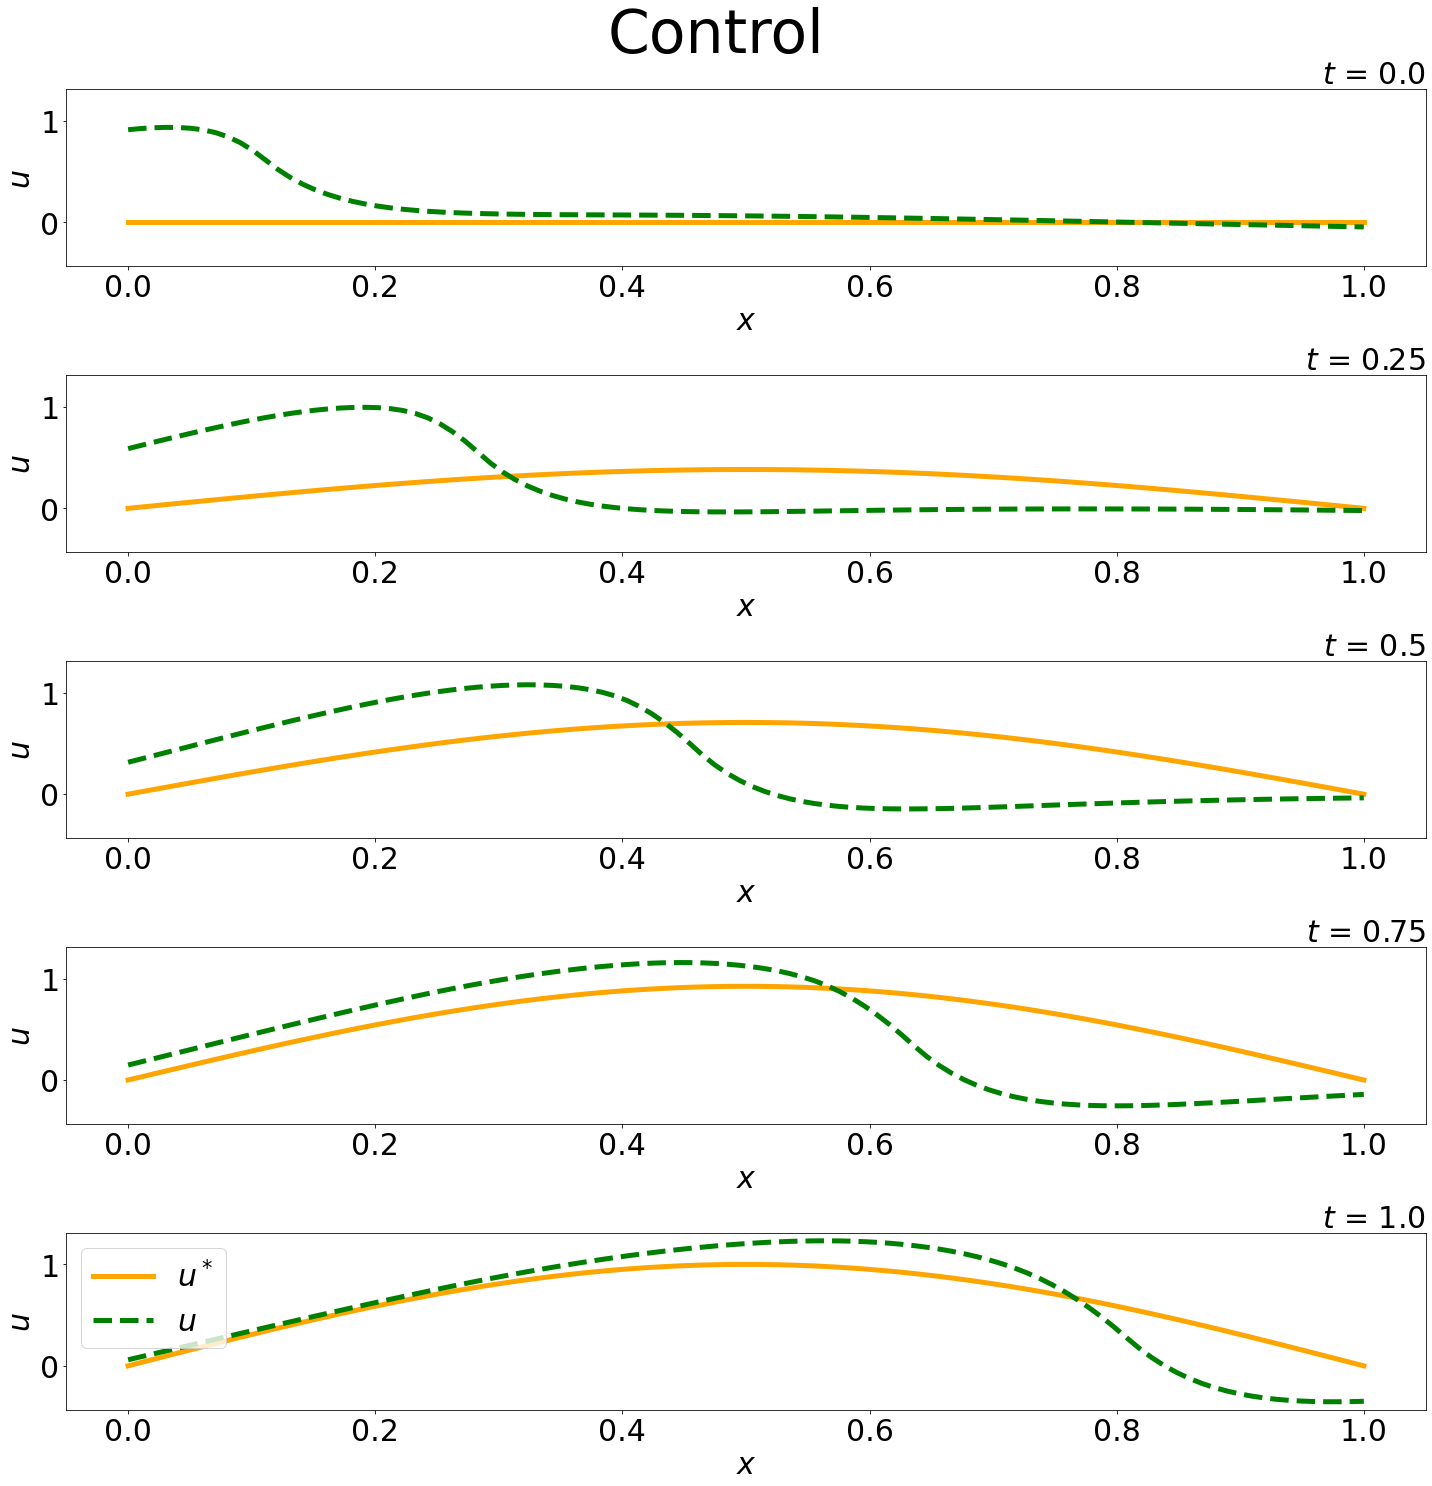

In [16]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')
timespan = 0.0
timespans = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axs = plt.subplots(5, sharex=False, sharey=True, figsize=(20,20),constrained_layout=True)
fig.suptitle('Control', size=60, y=1.03)

for i in range(len(timespans)):
  axs[i].plot(x_plot, u_ref(timespans[i], x_plot), 'orange',label='$u^*$', linewidth=5)
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[i], 100)),(-1,1)),
            tf.reshape(tf.constant(x_plot), (-1,1)))
  axs[i].plot(x_plot, pred[:,2], '--g', label='$u$', linewidth=5)
  axs[i].set_xlabel('$x$', fontsize=30)
  axs[i].set_ylabel('$u$', fontsize=30)
  axs[i].set_title(f'$t$ = {timespans[i]}', loc='right', size=30)
  axs[i].tick_params(axis='x', labelsize=30)
  axs[i].tick_params(axis='y', labelsize=30)

plt.legend(loc='upper left', fontsize=30)
plt.tight_layout()
plt.show()